In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale = 1.2)
sns.set_style("whitegrid")
sns.set_palette(palette = "hls", desat = 1)# n_colors = 3,

In [2]:
df = pd.read_csv('results.csv', index_col="Unnamed: 0")  # TODO eliminate all unused columns
df.shape

df.replace(["object-centered","robot-centered","human-centered"], ["OC", "RC", "HC"], inplace=True)

### Influence of one variable into another

<Figure size 504x504 with 0 Axes>

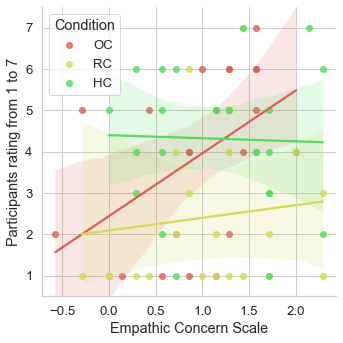

In [3]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Empathic Concern Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/Empathic Concern scale on influence.pdf",bbox_inches='tight')

<Figure size 504x504 with 0 Axes>

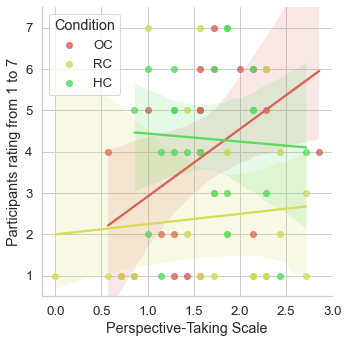

In [4]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Perspective-Taking Scale",
    y="Do you think the manner the robot addressed the object influenced how much time you spent helping it?",
    hue='Condition',
    data=df.fillna(1),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylabel="Participants rating from 1 to 7")
g.set(ylim=(0.5, 7.5))
plt.savefig(f"figures/PT scale on influence.pdf",bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/robust/robust_linear_model.py:290: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


<Figure size 504x504 with 0 Axes>

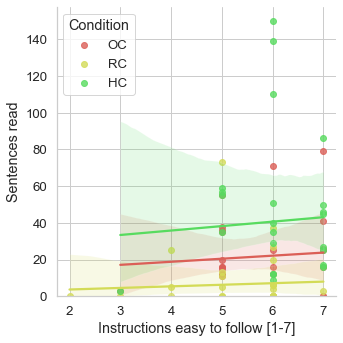

In [5]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Instructions easy to follow [1-7]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Instruction difficulty on sentences read.pdf",bbox_inches='tight')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/robust/robust_linear_model.py:290: ConvergenceWarning: Estimated scale is 0.0 indicating that the most last iteration produced a perfect fit of the weighted data.
  'weighted data.', ConvergenceWarning)


<Figure size 504x504 with 0 Axes>

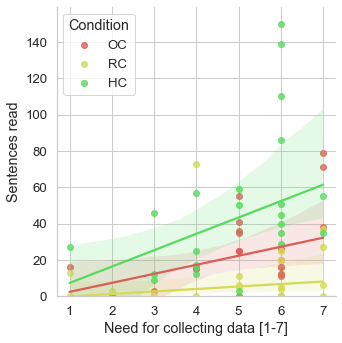

In [6]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Need for collecting data [1-7]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))
plt.savefig(f"figures/Need data on sentences read.pdf",bbox_inches='tight')

<Figure size 504x504 with 0 Axes>

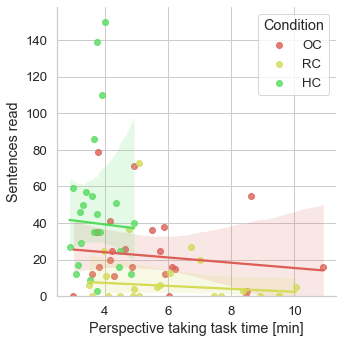

In [7]:
plt.figure(figsize=(7.0, 7.0))
g = sns.lmplot(
    x="Perspective taking task time [min]",
    y="Sentences read",
    hue='Condition',
    data=df.fillna(0),
    robust=True,
    facet_kws = {"legend_out" : False}
    )
g.set(ylim=(0, None))

plt.savefig(f"figures/PT time on sentences read.pdf",bbox_inches='tight')

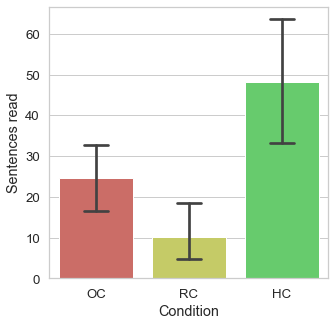

In [38]:
plt.figure(figsize=(5.0, 5.0))
g = sns.barplot(
    data=df.fillna(0),
    x="Condition",
    y="Sentences read",
    capsize = 0.25
)
plt.savefig("figures/PT time on sentences read histogram.pdf",bbox_inches='tight')  

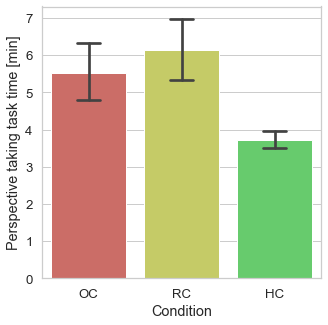

In [35]:
plt.figure(figsize=(5.0, 5.0))
g = sns.barplot(
    data=df.fillna(0),
    x="Condition",
    y="Perspective taking task time [min]",
    capsize = 0.25
)
plt.savefig("figures/PT time histogram.pdf",bbox_inches='tight')  

### Heat map: conditoin versus reverse condition

Create a CMAP from a discret pallet, highlightning the transition red -> yellow representing the small values. Why? Because in the heatmap, the total column has high values, and by increasing the contrast before in the continous scale, I'm adding more contrast in on the heatmap per se.

In [39]:
from matplotlib.colors import ListedColormap

colorarray = list(sns.hls_palette()[:3])
increment = [[colorarray[1][0]-colorarray[0][0], colorarray[1][1]-colorarray[0][1], colorarray[1][2]-colorarray[0][2]],[colorarray[2][0]-colorarray[1][0], colorarray[2][1]-colorarray[1][1], colorarray[2][2]-colorarray[1][2]]]
threshold = 49.0    # to control each increment is more significative in the continuous map
for i in range(98):
    if i < threshold: colorarray.insert(i+1,[colorarray[i][j]+increment[0][j]/threshold for j in range(3)]) # between red and yellow
    else: colorarray.insert(i+2,[colorarray[i+1][j]+increment[1][j]/(98-threshold) for j in range(3)]) # between yellow and green

cmap = ListedColormap(colorarray)

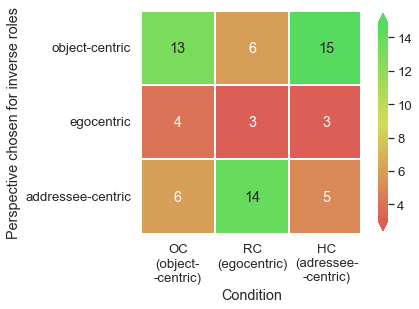

In [40]:
df_aux = df[["Condition", "If you were to tell the robot to pick up the objects how would you do it?"]].value_counts().copy()
df_heatmap = pd.DataFrame(columns=["Condition", "Perspective chosen for inverse roles", 'Occurrences'], dtype="float")
for condition_pair, occupance, in df_aux.iteritems():
    ideal_condition = "addressee-centric" if "your" in condition_pair[1] else "egocentric" if "my" in condition_pair[1] else "object-centric"
    df_heatmap = df_heatmap.append({
        "Condition": condition_pair[0],
        "Perspective chosen for inverse roles": ideal_condition,
        'Occurrences': occupance},
        ignore_index=True)

total = df_heatmap[["Perspective chosen for inverse roles", "Occurrences"]].groupby("Perspective chosen for inverse roles").sum().to_dict()["Occurrences"]
for key, value in total.items():
    df_heatmap = df_heatmap.append({
        "Condition": "total",
        "Perspective chosen for inverse roles": key,
        'Occurrences': value},
        ignore_index=True)

df_heatmap = df_heatmap.pivot("Perspective chosen for inverse roles", "Condition", "Occurrences")
# sorting
df_heatmap = df_heatmap[["OC", "RC", "HC"]]#, "total"
df_heatmap = df_heatmap.reindex(["object-centric", "egocentric", "addressee-centric"])
df_heatmap.rename(columns = {"OC":"OC\n(object-\n-centric)", "RC": "RC\n(egocentric)", "HC": "HC\n(adressee-\n-centric)"}, inplace = True)

plt.figure(figsize=(5.0, 5.0))
ax = sns.heatmap(df_heatmap, annot=True, cmap = cmap, square="True", cbar_kws={"extend": "both", "shrink": 0.8}, robust=True, linewidths=0.05)
ax.axvline(3, color='white', lw=8)
plt.yticks(rotation=0)
plt.savefig(f"figures/Condition_chosen_for_inverse_roles.pdf",bbox_inches='tight')

# Statistical Tests

In [16]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

In [23]:
def statistical(df, metric, fillna = 0):
    
    if fillna==False and type(fillna)==bool: df = df.dropna(subset = [metric])


    #perform one-way ANOVA
    anova = f_oneway(
        list(df[df["Condition"]=="OC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="RC"][metric].fillna(fillna)),
        list(df[df["Condition"]=="HC"][metric].fillna(fillna))
    )

    print(anova)

    # perform Tukey's test
    tukey = pairwise_tukeyhsd(endog=df[metric].fillna(fillna),
                            groups=df['Condition'],
                            alpha=0.05)

    # display results
    print(tukey)

    # compute the starts
    stars_boundaries = [5e-2, 1e-2, 1e-3, 1e-4]
    stars = ['*'*list(pair<=stars_boundaries).count(True) + " "*list(pair<=stars_boundaries).count(False) for pair in tukey.pvalues]
    print(stars)


In [24]:
statistical(df, "Perspective taking task time [min]")

F_onewayResult(statistic=12.848477834962202, pvalue=1.9374816569309807e-05)
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
    HC     OC   1.7983 0.0015  0.6155 2.9811   True
    HC     RC    2.404    0.0  1.2212 3.5867   True
    OC     RC   0.6057 0.4412 -0.5771 1.7884  False
---------------------------------------------------
['**  ', '****', '    ']


### Chi Square test - survey

In [ ]:
df_chi = df_heatmap.drop("total", axis=1)
chi2_contingency(df_chi)
chi2_contingency(df_chi[["OC\n(object-\n-centric)", "RC\n(egocentric)"]])
chi2_contingency(df_chi[["HC\n(adressee-\n-centric)", "RC\n(egocentric)"]])
chi2_contingency(df_chi[["HC\n(adressee-\n-centric)", "OC\n(object-\n-centric)"]])